## Group Work By
### - Devesh Lenka
### - Sun Zerui
### - Wang Chengfan
### - Wu Xianyuan

### Content
### [Part I Strategy Building](#strat)
#### [1.1 Momentum Strategy](#mo)
#### [1.2 Mean Reversion Strategy](#me)
#### [1.3 Machine Learning](#ma)
<br>

### [Part II Backtesting, Visualization and Performance Metrics](#Ba)
#### [2.1 Momentum Strategy](#moo)
#### [2.2 Mean Reversion Strategy](#mee)
#### [2.3 Machine Learning](#maa)
<br>

### [Part III Summary](#sum)
#### [Strategy A](#a)
#### [Strategy B](#b)
#### [Strategy C](#c)

### [Teamwork](#te)

<a id="strat"></a>

# Part I `Strategy Building`

In [1]:
import numpy as np
import pandas as pd

import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.simplefilter("ignore")
import datetime as dt
from pandas_datareader import data as pdr

np.set_printoptions(precision = 3)

pd.set_option("precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

<a id="mo"></a>

## 1.1 `Momentum` Strategy

### 1.1.1 Moving Average `window tuning`
Through the simple momentum trading strategy, we expect that the SP500 index price tend to continue the pattern in the short term and back to the normal level or average level in the long term. After continuously tuning and screening the moving average window, we finally selected 7 days for the short duration and 8 days for the long duration as the most appropriate window. Based on the above optimal duration, we use it to obtain “Buy or Sell,” “positions,”” return” and then to get the “strategy” (simple momentum strategy) we need. Similarly, the” cumulative return” and “max gross profit” of both our strategy and SP500 benchmark can be calculated. The following are different technical indicators under our simple momentum strategy. 

In [2]:
def ma_stra_return(ticker,start,end,sma_days,lma_days):
    data = pdr.get_data_yahoo(ticker,
                            start = start,
                            end = end
                            ).dropna()

    from tqdm import tqdm
    data["Buy_or_Sell"] = 0.0
    
    order_list = []
    performance_list = []
    
    for i in tqdm(sma_days):
        data[f"SMA{i}"] = data["Adj Close"].rolling(window = i,
                                       min_periods = 1
                                         ).mean()
        
        for j in lma_days:
            order = (i,j)
            
            if i < j:
                data[f"LMA{j}"] = data["Adj Close"].rolling(window = j,
                                           min_periods = 1
                                             ).mean()
            
                data["Buy_or_Sell"] = np.where(data[f"SMA{i}"] >
                                        data[f"LMA{j}"],
                                        1.0, 0.0)
            
                data["positions"] = data["Buy_or_Sell"].diff()
                data["return"] = np.log(data["Adj Close"]/data["Adj Close"].shift(1))
                data["strategy"] = data["positions"].shift(1) * data["return"]
            
                strategy_return = data["strategy"].dropna().cumsum().apply(np.exp)
                best_cfg = order
            
                strategy_max = strategy_return.max()
            
                order_list.append(best_cfg)
                performance_list.append(strategy_max)
            
            else:
                continue
                     
    return pd.DataFrame(performance_list,index = order_list, columns = ["cumulative_return"])

In [3]:
start = dt.datetime(2002,11,1)
end = dt.datetime(2021,10,31)
sma_days = np.arange(1,100)
lma_days = np.arange(2,500)
best_pick = ma_stra_return("SPY",start,end,sma_days,lma_days)
best_pick.sort_values(by = "cumulative_return",ascending = False).head(1)

100%|██████████| 99/99 [03:00<00:00,  1.82s/it]


,cumulative_return
"(7, 8)",2.131


<a id="mon"></a>

### 1.1.2 New defined momentum 
The indicator comes from the momentum of momentum (moving average in change of price change). 
Under this new strategy, the first step is still to tune and screen out the most appropriate window, 
which help us obtain 55 days for the short duration and 70 days for the long duration as the best window. Based on the above optimal duration, we backtest it to obtain “Buy or Sell,” “positions,”” return” and then to get the “strategy” we need. Similarly, the” cumulative return” and “max gross profit” of both our new strategy and SP500 benchmark can be calculated. Surprisingly, from our plot, we can find that our new strategy largely exceeds the return.  

#### Find best Moving average window 

In [4]:
def dma_stra_return(ticker,start,end,sma_days,lma_days):
    data = pdr.get_data_yahoo(ticker,
                            start = start,
                            end = end
                            ).dropna()
    
    data["pdiff"] = data["Adj Close"] - data["Adj Close"].shift(1)
    data["pdiff2"] = data["pdiff"] - data["pdiff"].shift(1)
    data["pdiff3"] = data["pdiff2"] - data["pdiff2"].shift(1)

    from tqdm import tqdm
    data["Buy_or_Sell"] = 0.0
    
    order_list = []
    performance_list = []
    
    for i in tqdm(sma_days):
        data[f"SMA{i}"] = data["pdiff3"].rolling(window = i,
                                       min_periods = 1
                                         ).mean()
        
        for j in lma_days:
            order = (i,j)
            
            if i < j:
                data[f"LMA{j}"] = data["pdiff3"].rolling(window = j,
                                           min_periods = 1
                                             ).mean()
            
                data["Buy_or_Sell"] = np.where(data[f"SMA{i}"] >
                                        data[f"LMA{j}"],
                                        1.0, 0.0)
            
                data["positions"] = data["Buy_or_Sell"].diff()
                data["return"] = np.log(data["Adj Close"]/data["Adj Close"].shift(1))
                data["strategy"] = data["positions"].shift(1) * data["return"]
            
                strategy_return = data["strategy"].dropna().cumsum().apply(np.exp)
                best_cfg = order
            
                strategy_max = strategy_return.max()
            
                order_list.append(best_cfg)
                performance_list.append(strategy_max)
            
            else:
                continue
                     
    return pd.DataFrame(performance_list,index = order_list, columns = ["cumulative_return"])

In [5]:
start = dt.datetime(2002,11,1)
end = dt.datetime(2021,10,31)
sma_days = np.arange(1,200)
lma_days = np.arange(2,300)
best_pick = dma_stra_return("SPY",start,end,sma_days,lma_days)
best_pick.sort_values(by = "cumulative_return",ascending = False).head(1)

100%|██████████| 199/199 [02:36<00:00,  1.27it/s]


,cumulative_return
"(55, 70)",15.855


<a id="me"></a>

## 1.2 `Mean Reversion`

### 1.2.1 Moving Average window tuning

We expect that the index prices tend to return back to normal or average level after an extreme price move, so we apply mean reversion strategy to the S&P500 index. To find the rolling windows of a certain SMA that can give us the highest return rate, we take moving windows of 5 to 120 days with a step of 5 days to calculate the simple moving average (SMA), and use the simple moving standard deviation as the threshold to calculate the degree of price deviation relative to the SMA to derive our positions and the strategy returns.  

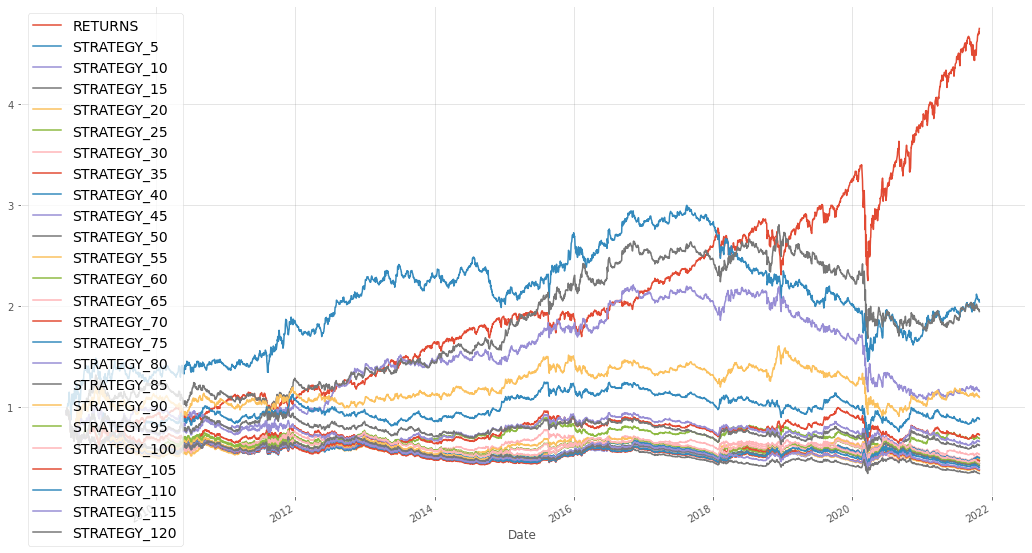

In [6]:
SP500 = pdr.get_data_yahoo("SPY",
                            start = start,
                            end = end
                            ).dropna()
closing_prices = SP500[["Adj Close"]]
MR = closing_prices.copy().rename(columns = {'Adj Close': 'Price'})

MR['RETURNS'] = np.log(MR['Price'] / MR['Price'].shift(1)
                      )
    
windows = np.arange(0, 125, 5)

list_for_plot = ['RETURNS']
exceed = []
for w in windows[1:]:

    MR['SMA_R'] = MR['Price'].rolling(w).mean()

    #defince threshold as moving standand deviation of price
    MR['Std_Dev'] = MR['Price'].rolling(w).std()
    MR['DIST'] = MR['Price'] - MR['SMA_R']
    MR.dropna(inplace = True)

    #MR['DIST'].plot(figsize = (20, 8)
     #          )
    #plt.show()
    
    MR['POSITION_%d' %w] = np.where(MR['DIST'] > MR['Std_Dev'], 
                         -1, np.nan
                         )
    MR['POSITION_%d' %w] = np.where(MR['DIST'] < -MR['Std_Dev'], 
                         1, MR['POSITION_%d' %w]
                         )
    MR['POSITION_%d' %w] = np.where(MR['DIST'] * MR['DIST'] < 0, 
                         0, MR['POSITION_%d' %w]
                         )

    MR['POSITION_%d' %w] = MR['POSITION_%d' %w].ffill()
    MR['POSITION_%d' %w] = MR['POSITION_%d' %w].fillna(0)
    
    MR['STRATEGY_%d' %w] = MR['POSITION_%d' %w].shift(1) * MR['RETURNS']
    
    list_for_plot.append('STRATEGY_%d' %w)
    exceed.append(MR[['STRATEGY_%d' %w]].dropna().sum().apply(np.exp)[0] - MR[['RETURNS']].dropna().sum().apply(np.exp)[0])
    
MR[list_for_plot].dropna().cumsum().apply(np.exp).plot(figsize = (18, 10))
plt.show()

By comparing the returns of each strategy, we can find that the strategy with the highest return 2.052% is the one with a 5-day moving window:

In [7]:
print('Best Strategy is ', str(list_for_plot[exceed.index(max(exceed)) + 1]), ' with excess return of ', str(max(exceed)))

Best Strategy is  STRATEGY_5  with excess return of  -2.214423010949557


In [8]:
MR[['STRATEGY_5']].dropna().sum().apply(np.exp)[0]

2.0516837156760186

<a id="mei"></a>

### 1.2.2 Intraday Mean Reversion MA window tuning

Since S&P500 index price is not so volatile, the performance of the usual mean reversion may not beat the market. We continue to do intraday trading by taking moving windows of 1 minute to 240 minutes with a step of 1 minutes. Among the trading returns, the highest one is 1.027% with the rolling window of 210 minutes. 

#### Intraday Trading with rolling minutes (over 7 days before 2021-10-31)

In [9]:
IntraMR = yf.download(tickers = 'SPY', 
                start = dt.datetime.strptime('2021-10-31', '%Y-%m-%d') - dt.timedelta(7), 
                end = end,
                interval = '1m', 
                auto_adjust = True).dropna()

[*********************100%***********************]  1 of 1 completed


In [10]:
IntraMR = IntraMR[['Close']].rename(columns = {'Close': 'Price'})
IntraMR['RETURNS'] = np.log(IntraMR['Price'] / IntraMR['Price'].shift(1)
                           )
IntraMR.dropna(inplace = True)
IntraMR

,Price,RETURNS
Datetime,,
2021-10-25 09:31:00-04:00,454.070,-0.000
2021-10-25 09:32:00-04:00,454.040,-0.000
2021-10-25 09:33:00-04:00,453.680,-0.001
2021-10-25 09:34:00-04:00,453.690,0.000
2021-10-25 09:35:00-04:00,453.720,0.000
...,...,...
2021-10-29 15:55:00-04:00,459.410,-0.000
2021-10-29 15:56:00-04:00,459.220,-0.000
2021-10-29 15:57:00-04:00,459.405,0.000


In [11]:
intra_list = ['RETURNS']
intra_exceed = []
N = np.arange(1, 240, 1)
for n in N:
    IntraMR['SMA_R'] = IntraMR['Price'].rolling(n).mean()
    IntraMR['Std_Dev'] = IntraMR['Price'].rolling(n).std()
    IntraMR['DIST'] = IntraMR['Price'] - IntraMR['SMA_R']
    #IntraMR.dropna(inplace = True)
    
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] > IntraMR['Std_Dev'], 
                         -1, np.nan
                         )
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] < -IntraMR['Std_Dev'], 
                         1, IntraMR['POSITION_%d' %n]
                         )
    IntraMR['POSITION_%d' %n] = np.where(IntraMR['DIST'] * IntraMR['DIST'] < 0, 
                         0, IntraMR['POSITION_%d' %n]
                         )

    IntraMR['POSITION_%d' %n] = IntraMR['POSITION_%d' %n].ffill()
    IntraMR['POSITION_%d' %n] = IntraMR['POSITION_%d' %n].fillna(0)
    
    IntraMR['STRATEGY_%d' %n] = IntraMR['POSITION_%d' %n].shift(1) * IntraMR['RETURNS']
    
    intra_list.append('STRATEGY_%d' %n)
    intra_exceed.append(IntraMR[['STRATEGY_%d' %n]].dropna().sum().apply(np.exp)[0] - IntraMR[['RETURNS']].dropna().sum().apply(np.exp)[0])
#IntraMR[intra_list].cumsum().apply(np.exp).plot(figsize = (18, 10))
#plt.legend(loc = "right")
#plt.show()

In [12]:
print('Max Strategy is ', str(intra_list[intra_exceed.index(max(intra_exceed)) + 1]), ' with excess return of ', str(max(intra_exceed)))

Max Strategy is  STRATEGY_210  with excess return of  0.015934549779576646


In [13]:
IntraMR[['STRATEGY_210']].dropna().sum().apply(np.exp)

STRATEGY_210   1.027
dtype: float64

### 1.2.3 RSI Strategy Upper Bound and Lower Bound Tuning

To further improve the strategy, we use the relavent strength index (RSI), which  is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. We set the level of overbought and the level of oversold as the threshold, we use momentum strategy within the upperbound and the lower bound, i.e. long the asset between the upper bound and 50 level and short the asset between 50 level and the lower bound. When exceeding the upper bound and the lowerbound, we apply to mean reversion strategy, i.e. short the asset when above the upperbound and long the asset when below the lower bound. 

In [14]:
import talib

In [15]:
rsi = pd.DataFrame(SP500['Adj Close'], index = SP500.index)
rsi.rename(columns = {'Adj Close': 'Price'}, inplace = True)
rsi['RETURNS'] = np.log(rsi['Price'] / rsi['Price'].shift(1))
rsi['RSI'] = talib.RSI(SP500['Adj Close'])
rsi.dropna(inplace = True)

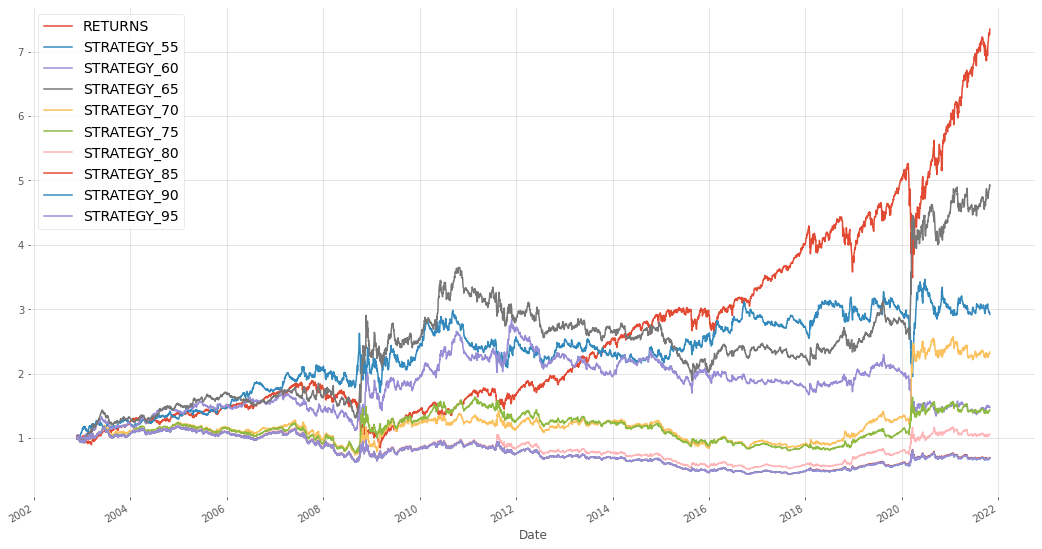

In [16]:
rsi_list = ['RETURNS']
rsi_exceed = []
for n in np.arange(55, 100, 5):
    position = 0
    positions = []
    for i in range(len(rsi.index)):
        if (rsi['RSI'][i] < 50) & (rsi['RSI'][i] > 100 - n):
            position = -1
        elif rsi['RSI'][i] < n:
            position = 1
        elif (rsi['RSI'][i] > 50) & (rsi['RSI'][i] < n):
            position = 1
        elif rsi['RSI'][i] > n:
            position = -1
        positions.append(position)
    rsi_list.append('STRATEGY_%d' % n)
    rsi['POSITION_%d' % n] = positions
    rsi['STRATEGY_%d' % n] = rsi['POSITION_%d' % n].shift(1) * rsi['RETURNS']
    rsi_exceed.append(rsi[['STRATEGY_%d' % n]].dropna().sum().apply(np.exp)[0] - rsi[['RETURNS']].dropna().sum().apply(np.exp)[0])
rsi[rsi_list].cumsum().apply(np.exp).plot(figsize = (18, 10))
plt.show()

By taking the upper bound varying from 55 to 95 level with a step of 5, we compare each of the return and get the highest one of 4.924 with the upper bound of 65 and the lower bound of 35. 

In [17]:
print('Max Strategy is ', str(rsi_list[rsi_exceed.index(max(rsi_exceed)) + 1]), ' with excess return of ', str(max(rsi_exceed)))

Max Strategy is  STRATEGY_65  with excess return of  -2.427313300920268


In [18]:
rsi[['STRATEGY_65']].dropna().sum().apply(np.exp)

STRATEGY_65   4.924
dtype: float64

<a id="ma"></a>

## 1.3 `Machine Learning` Strategy

In [19]:
closing_prices["Return"] = np.log(closing_prices["Adj Close"]
                                 ).diff(1).shift(1)
                      

closing_prices.dropna(inplace=True)

In [20]:
closing_prices

,Adj Close,Return
Date,,
2002-11-04,63.008,0.020
2002-11-05,63.506,0.009
2002-11-06,64.328,0.008
2002-11-07,62.752,0.013
2002-11-08,61.985,-0.025
...,...,...
2021-10-25,455.550,-0.001
2021-10-26,455.960,0.005
2021-10-27,453.940,0.001


#### Activate Necessary Packages

> For the supervised regression models

In [21]:
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Bagging
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

> For data analysis and model evaluation

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

> For deep learning models

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.optimizers import SGD

from keras.wrappers.scikit_learn import KerasRegressor

> For time series models

In [24]:
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

> For data preparation and visualization

In [25]:
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

In [26]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

The code below is used to create our independent variables. The first chunk of code is used to create 5 lags of daily returns which will be used to help us predict the daily return going forward.
The next bit of code extracts data for the dollar index and the 10 year tresury yield. These variables have interesting relationships with the S&P 500 index. 
The DXY overall has a positive correlation with the S&P500 as foreign investment into the index causes the value of the dollar to appreciate as well. On the other hand, during times of global uncertainity where market crashes are sudden and large (GFC in 2008 and Covid in 2020) the DXY becomes a safe haven asset and appreciates in value exhibiting a negative correlation with the index. 
The 10 year yield also has a nuanced relationship with the index. During downturns, bond yields drop due to interest rates being kept low by the central banks to promote economic growth. During late economic expansions, typically yields rise in order to curtail inflation. Ever since the Global Financial crisis, bond yields haven't truly recovered due to quantitative easing carried out by the central banks.

By including the DXY and 10 year yields in the model, we hope to increase our prediction of market downturns which are a deviation from the usual up trend of the index over the last 20 years. Catching these downtrends early will lead to improved model performance. 

In [27]:
closing_prices_lags = closing_prices.copy()
lags = 5
cols = []

for i in range(1, lags + 1):
    
    col = f"lag_{i}"
    closing_prices_lags[col] = closing_prices_lags["Return"].shift(i)
    cols.append(col)
    
closing_prices_lags.dropna(inplace=True)

In [28]:
ticker = ["DX-Y.NYB", "^TNX"]

data = pdr.DataReader(ticker,
                     "yahoo",
                     start = start,
                     end = end
                     )

In [29]:
X1 = np.log(data["Adj Close"].loc["2002-10-30":]
           ).diff(1).shift(1)

X1.dropna(inplace = True)

X2 = closing_prices_lags[cols]

X = pd.concat([X1, X2], 
              axis = 1,
              join = "inner"
             )

Y = closing_prices.loc[X.index][["Return"]]

dataset = pd.concat([Y, X], 
                   axis = 1
                   )

The image below illustrates the correlation between the index return and its explanatory variables.

<AxesSubplot:title={'center':'Correlation Matrix'}>

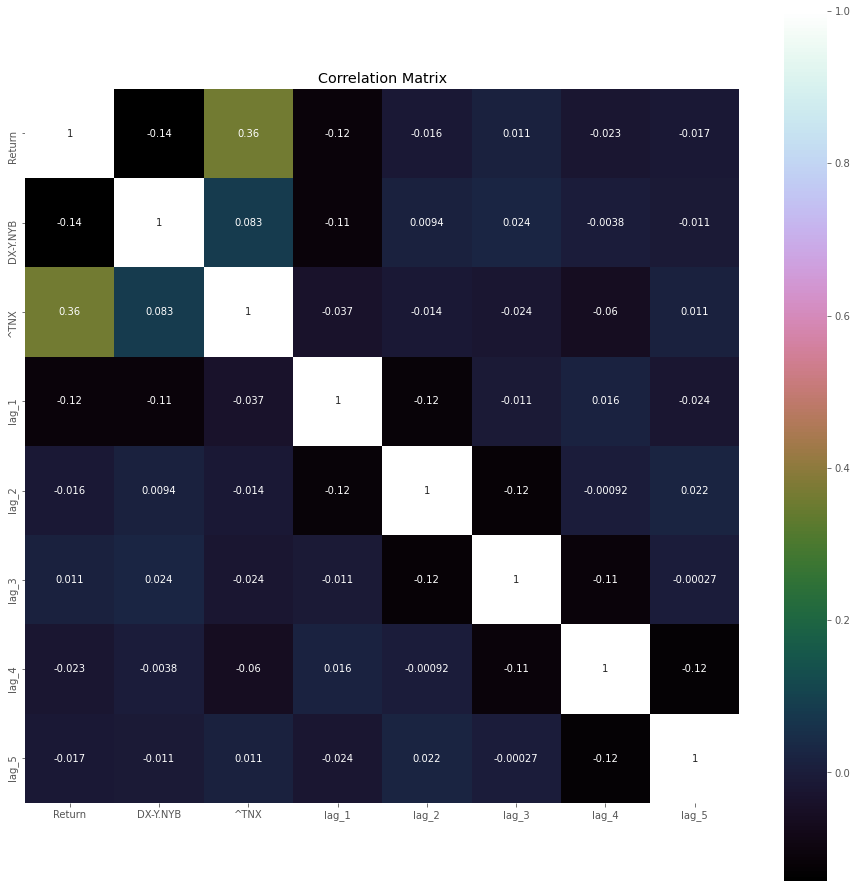

In [30]:
correlation = dataset.corr()

plt.figure(figsize = (16, 16)
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            annot = True,
            cmap = "cubehelix"
           )

The next section enables us to pick a suitable machine learning algorithm to build our model. For maximising backtesting performance of in sample data, we want to pick the model with the least mean square error when fitted with the same data we backtest on. This will lead to picking the model with the greatest amount of overfitting. For the purposes of maximising in sample data, this is the methodology we are going to follow. 

In [31]:
validation_size = 0.2

train_size = int(len(X) * (1 - validation_size)
                 )

X_train, X_test = X[0:train_size], X[train_size:len(X)]

Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### Ten-fold Cross Validation and Evaluation Metrics

In [32]:
num_folds = 10
seed = 7
scoring = "neg_mean_squared_error"

### Fitting: Model Comparison with ML Algorithms

In [33]:
models = []

#### Regression and tree regression algorithms

In [34]:
models.append(("LR", LinearRegression()
              )
             )

models.append(("LASSO", Lasso()
              )
             )
    
models.append(("EN", ElasticNet()
              )
             )

models.append(("CART", DecisionTreeRegressor()
              )
             )

models.append(("KNN", KNeighborsRegressor()
              )
             )

models.append(("SVR", SVR()
              )
             )

#### Neural network algorithms

In [35]:
models.append(("MLP", MLPRegressor()
              )
             )

#### Ensemble models

In [36]:
# Bagging

models.append(("ETR", ExtraTreesRegressor()
              )
             )

models.append(("RFR", RandomForestRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [37]:
names = []

kfold_results = []

train_results = []
test_results = []

for name, model in models:
    names.append(name)
    
    # K-Fold analysis
    
    kfold = KFold(n_splits = num_folds,
                  random_state = seed,
                 shuffle = True)
    
    # MSE
    
    cv_results = -1 * cross_val_score(model, X_train, Y_train,
                                      cv = kfold,
                                      scoring = scoring)
    
    kfold_results.append(cv_results) 
    
    # Training period
    
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Testing period
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(message)

LR: 0.000111 (0.000024) 0.000108 0.000161
LASSO: 0.000132 (0.000030) 0.000132 0.000181
EN: 0.000132 (0.000030) 0.000132 0.000181
CART: 0.000220 (0.000057) 0.000000 0.000231
KNN: 0.000123 (0.000026) 0.000080 0.000168
SVR: 0.000301 (0.000082) 0.000291 0.000337
MLP: 0.000112 (0.000025) 0.000109 0.000156
ETR: 0.000116 (0.000026) 0.000000 0.000180
RFR: 0.000120 (0.000030) 0.000017 0.000173
GBR: 0.000119 (0.000032) 0.000064 0.000185
ABR: 0.000119 (0.000029) 0.000094 0.000188


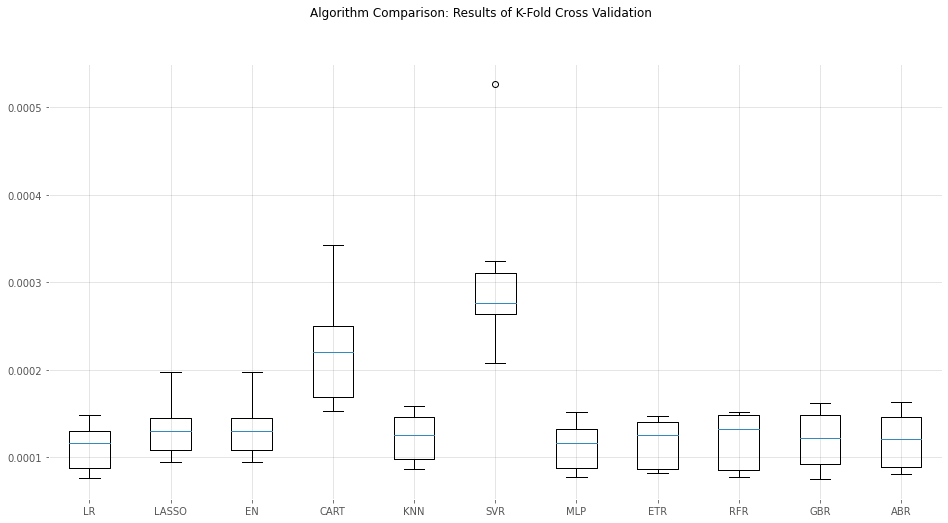

In [38]:
fig = plt.figure(figsize = (16, 8)
                 )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

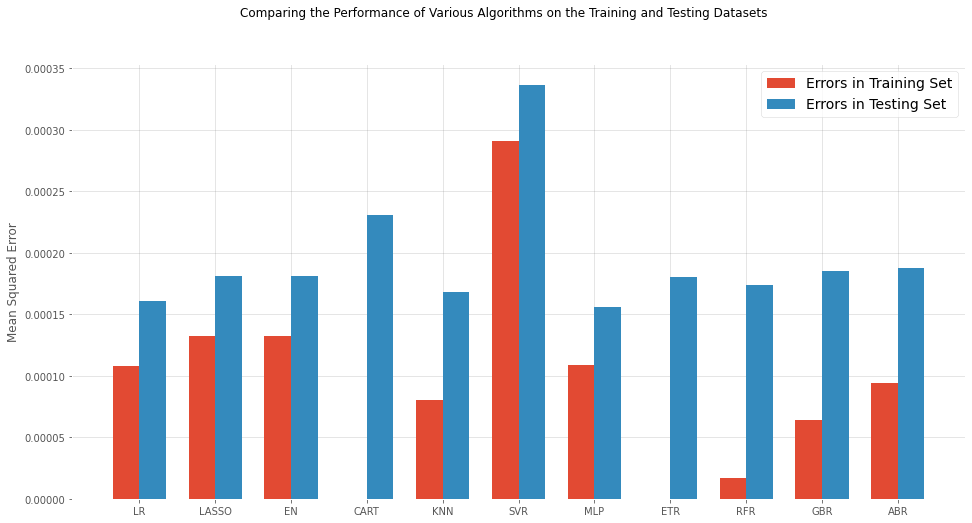

In [39]:
fig = plt.figure(figsize = (16, 8)
                 )

ind = np.arange(len(names)
               ) 
width = 0.35

fig.suptitle("Comparing the Performance of Various Algorithms on the Training and Testing Datasets")
ax = fig.add_subplot(111)

plt.bar(ind - width/2, 
        train_results, 
        width = width,
        label = "Errors in Training Set")

plt.bar(ind + width/2, 
        test_results, 
        width = width,
        label = "Errors in Testing Set")

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error")

plt.show()

As observed from the bar chart above, the Extra trees regressor has the smallest MSE out of all models for the testing data. 
ETR implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy. 

In [40]:
for name, model in models:
    
    model.fit(X,
              Y["Return"]
             )
    
    Y[name] = Y["Return"] * np.sign(model.predict(X
                                                 )
                                   ) 
    message = "%s: %f " % (name, accuracy_score(np.sign(model.predict(X)),
                                                np.sign(Y["Return"]
                                                        )
                                                       )
                                               )
    print(message)

LR: 0.598425 
LASSO: 0.553948 
EN: 0.553948 
CART: 1.000000 
KNN: 0.680996 
SVR: 0.554586 
MLP: 0.617365 
ETR: 1.000000 
RFR: 0.914876 
GBR: 0.646095 
ABR: 0.608853 


## Find the optimal number of lags to be used

In [41]:
def extract(stocks, start, end):
    def data(ticker):
        return(pdr.get_data_yahoo(ticker,
                                  start = start, 
                                  end = end)
              )
    D = map(data, stocks)
    return(pd.concat(D,
                     keys = stocks,
                     names = ["Tickers", "Date"]
                    )
          )
SPY = extract(["SPY"],
             start = dt.datetime(2002,11,1),
             end = dt.datetime(2021,10,31)
             )
SPY = SPY[["Adj Close"]
               ].reset_index().pivot("Date",
                                    "Tickers",
                                    "Adj Close")
SPY["return"] = np.log(SPY["SPY"]/SPY["SPY"].shift(1))
SPY

Tickers,SPY,return
Date,,
2002-10-31,61.203,NaN
2002-11-01,62.413,0.020
2002-11-04,63.008,0.009
2002-11-05,63.506,0.008
2002-11-06,64.328,0.013
...,...,...
2021-10-25,455.550,0.005
2021-10-26,455.960,0.001
2021-10-27,453.940,-0.004


In [42]:
def find_best_lags_ETC(SPY,lag_length):
    from sklearn.ensemble import ExtraTreesClassifier
    from tqdm import tqdm
    performance_list = []
    for i in tqdm(lag_length):        
        lags = i
        cols = []
        SPY_lag = SPY.copy()
        
        for j in range(1, lags+1):
            col = f"lag_{j}"
            SPY_lag[col] = SPY_lag["return"].shift(j)
            cols.append(col)
        SPY_lag.dropna(inplace = True)
    
        model_ETC = ExtraTreesClassifier()
        model_ETC.fit(SPY_lag[cols],
                    np.sign(SPY_lag["return"])
                        )
    
        SPY_lag[f"prediction_ETC_{j}"] = model_ETC.predict(SPY_lag[cols]
                                              )   
        SPY_lag[f"strategy_ETC_{j}"] = SPY_lag["return"] * SPY_lag[f"prediction_ETC_{j}"]
        SPY_lag[f"strategy_ETC_{j}"] = SPY_lag["return"] * SPY_lag[f"prediction_ETC_{j}"]
        performance = SPY_lag[f"strategy_ETC_{j}"].cumsum().apply(np.exp)[-1]
    
        performance_list.append(performance)    
    result_df = pd.DataFrame(performance_list,index = lag_length,columns = ["cumulative_return"])
    return result_df.sort_values(by = "cumulative_return",ascending = False).head(3)

In [43]:
lag_length = np.arange(1,100)
find_best_lags_ETC(SPY,lag_length)

100%|██████████| 99/99 [03:33<00:00,  2.15s/it]


,cumulative_return
2,4992639257198050.000
3,4953502519917854.000
4,4890149811056923.000


<a id="ba"></a>

# Part II `Backtesting, Visualization and Performance Metrics`

<a id="moo"></a>

## 2.1 Momentum Strategy

### 2.1.1 Momentum Strategy with `best Window` (7, 8)

In [44]:
SP500 = pdr.get_data_yahoo("SPY",
                            start = start,
                            end = end
                            ).dropna()
SP500 = SP500[["Adj Close"]]
SP500["Buy_or_Sell"] = 0.0

SP500["SMA"] = SP500["Adj Close"].rolling(window = 7,
                                       min_periods = 1
                                         ).mean()

SP500["LMA"] = SP500["Adj Close"].rolling(window = 8,
                                       min_periods = 1
                                         ).mean()


SP500["Buy_or_Sell"] = np.where(SP500["SMA"] >
                                    SP500["LMA"],
                                    1.0, 0.0)

SP500["positions"] = SP500["Buy_or_Sell"].diff()
SP500["return"] = np.log(SP500["Adj Close"]/SP500["Adj Close"].shift(1))
SP500["strategy"] = SP500["positions"].shift(1) * SP500["return"]

SP500["cumulative_return"] = SP500["strategy"].cumsum().apply(np.exp)
SP500["max_gross_profit"] = SP500["cumulative_return"].cummax()

SP500["cumulative_return_benchmark"] = SP500["return"].cumsum().apply(np.exp)
SP500["max_gross_profit_benchmark"] = SP500["cumulative_return_benchmark"].cummax()

#### 2.1.1.1 Buy and Sell Points

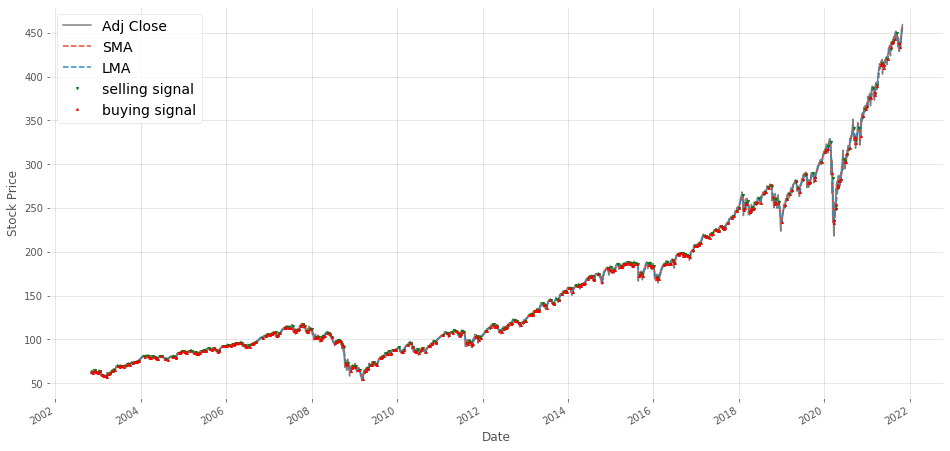

In [45]:
fig = plt.figure(figsize = (16,8))

sub = fig.add_subplot(111,
                      ylabel = 'Stock Price')
SP500["Adj Close"].plot(ax = sub,
                    color = 'grey')
SP500[["SMA","LMA"]].plot(ax = sub,
                               style = ['--','--'])
sub.plot(SP500.loc[SP500.positions==-1.0].index,
         SP500.SMA[SP500.positions ==-1.0],
         'gv',
         markersize = 2,
         label = 'selling signal')
sub.plot(SP500.loc[SP500.positions ==1.0].index,
         SP500.LMA[SP500.positions == 1.0],
         "r^",
         markersize = 2,
         label = 'buying signal')
plt.legend(loc = 0)

#### 2.1.1.2 Cumulative Return

,strategy,return
Date,,
2002-10-31,NaN,NaN
2002-11-01,NaN,1.020
2002-11-04,1.000,1.029
2002-11-05,1.000,1.038
2002-11-06,1.000,1.051
...,...,...
2021-10-25,1.973,7.443
2021-10-26,1.973,7.450
2021-10-27,1.973,7.417


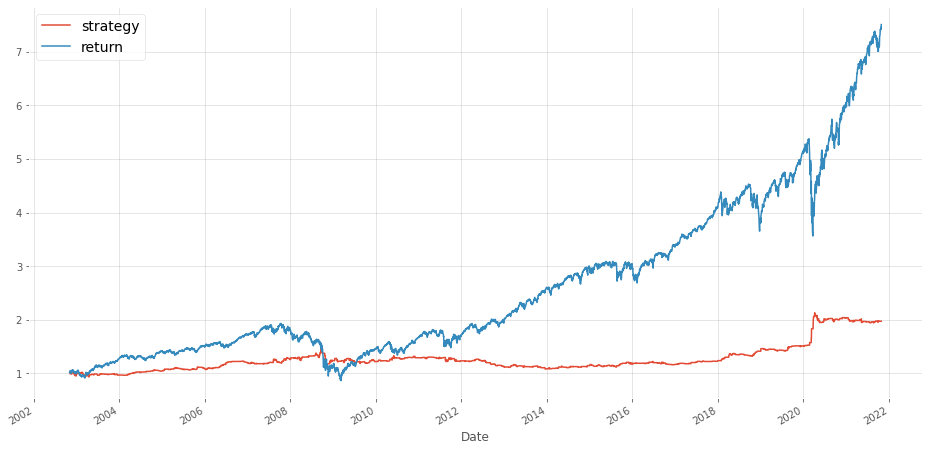

In [46]:
SP500[["strategy","return"]
     ].cumsum().apply(np.exp).plot(figsize = (16,8))
SP500[["strategy","return"]
     ].cumsum().apply(np.exp)

#### 2.1.1.3 Annual Growth Rate
##### Strategy Annual Growth Rate

In [47]:
return_ms = ((SP500["strategy"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("Our strategy AGR = %.3f percentage" % return_ms)

Our strategy AGR = 3.457 percentage


##### Benchmark Annual Growth Rate

In [48]:
return_mb = ((SP500["return"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("SP500 AGR = %.3f percentage" % return_mb)

SP500 AGR = 10.602 percentage


#### 2.1.1.4 Sharpe Ratio
##### Strategy Sharpe Ratio

In [49]:
sharpe_ms = np.sqrt(253) * SP500["strategy"].mean() / SP500["strategy"].std()
print("Our strategy Sharpe Ratio = %.3f" % sharpe_ms)

Our strategy Sharpe Ratio = 0.429


##### Benchmark Sharpe Ratio

In [50]:
sharpe_mb = np.sqrt(253) * SP500["return"].mean() / SP500["return"].std()
print("SP500 Sharpe Ratio = %.3f" % sharpe_mb)

SP500 Sharpe Ratio = 0.563


#### 2.1.1.5 Maximum Drawdown
##### Strategy Maximum Drawdown

In [51]:
drawdown_ms = (SP500["max_gross_profit"] - SP500["cumulative_return"])/ SP500["max_gross_profit"]
print("Our Strategy Maximum Drawdown is %.3f" % drawdown_ms.max())

Our Strategy Maximum Drawdown is 0.277


##### Benchmark Maximum Drawdown

In [52]:
drawdown_mb = (SP500["max_gross_profit_benchmark"] - SP500["cumulative_return_benchmark"])/SP500["max_gross_profit_benchmark"]
print("SP500 Maximum Drawdown is %.3f" % drawdown_mb.max())

SP500 Maximum Drawdown is 0.552


##### Drawdown comparison plot

<AxesSubplot:xlabel='Date'>

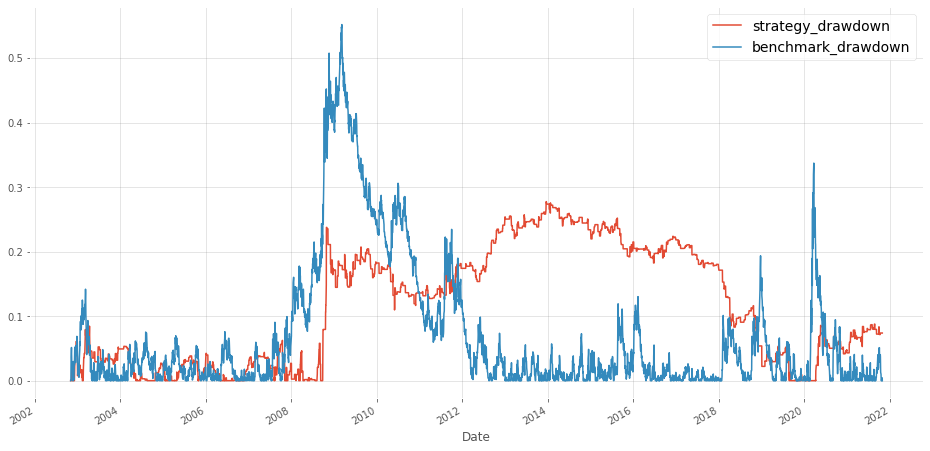

In [53]:
pd.DataFrame([drawdown_ms,drawdown_mb],index = ["strategy_drawdown","benchmark_drawdown"]).T.dropna().plot(figsize = (16,8))

#### 2.1.1.6 Final Capital after 20 Years
##### Our Strategy

In [54]:
500000 * SP500["cumulative_return"][-1]

986656.1353813041

##### Benchmark

In [55]:
500000 * SP500["cumulative_return_benchmark"][-1]

3751838.278603101

<a id="monba"></a>

### 2.1.2 New defined momentum¶
### Backtesting with best window (55,70)

In [56]:
SP500 = pdr.get_data_yahoo("SPY",
                            start = start,
                            end = end
                            ).dropna()
SP500["pdiff"] = SP500["Adj Close"] - SP500["Adj Close"].shift(1)
SP500["pdiff2"] = SP500["pdiff"] - SP500["pdiff"].shift(1)
SP500["pdiff3"] = SP500["pdiff2"] - SP500["pdiff2"].shift(1)
SP500["Buy_or_Sell"] = 0.0

SP500["SMA"] = SP500["pdiff3"].rolling(window = 55,
                                       min_periods = 1
                                         ).mean()

SP500["LMA"] = SP500["pdiff3"].rolling(window = 70,
                                       min_periods = 1
                                         ).mean()

SP500["Buy_or_Sell"] = np.where(SP500["SMA"] >
                                    SP500["LMA"],
                                    1.0, 0.0)

SP500["positions"] = SP500["Buy_or_Sell"].diff()
SP500["return"] = np.log(SP500["Adj Close"]/SP500["Adj Close"].shift(1))
SP500["strategy"] = SP500["positions"].shift(1) * SP500["return"]

SP500["cumulative_return"] = SP500["strategy"].cumsum().apply(np.exp)
SP500["max_gross_profit"] = SP500["cumulative_return"].cummax()

SP500["cumulative_return_benchmark"] = SP500["return"].cumsum().apply(np.exp)
SP500["max_gross_profit_benchmark"] = SP500["cumulative_return_benchmark"].cummax()

#### 2.1.2.1 Buy and Sell Points

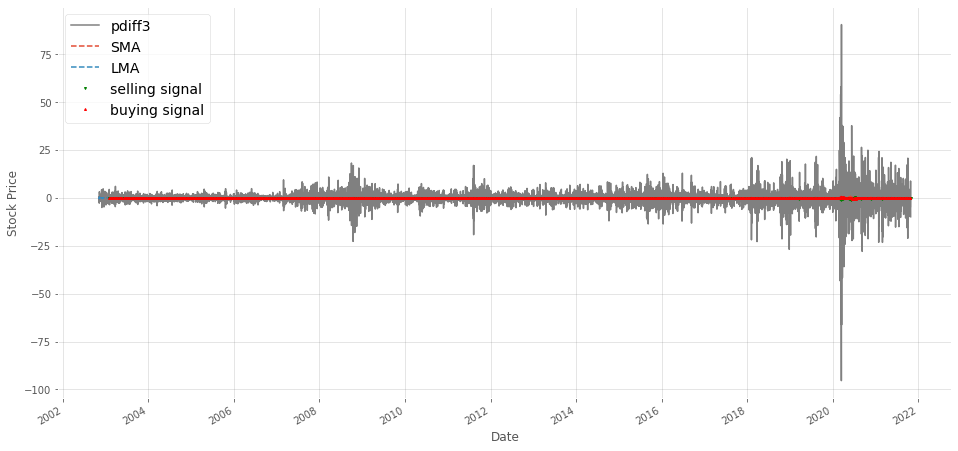

In [57]:
fig = plt.figure(figsize = (16,8))

sub = fig.add_subplot(111,
                      ylabel = 'Stock Price')
SP500["pdiff3"].plot(ax = sub,
                    color = 'grey')
SP500[["SMA","LMA"]].plot(ax = sub,
                               style = ['--','--'])
sub.plot(SP500.loc[SP500.positions==-1.0].index,
         SP500.SMA[SP500.positions ==-1.0],
         'gv',
         markersize = 2,
         label = 'selling signal')
sub.plot(SP500.loc[SP500.positions ==1.0].index,
         SP500.LMA[SP500.positions == 1.0],
         "r^",
         markersize = 2,
         label = 'buying signal')
plt.legend(loc = 0)

#### 2.1.2.2 Cumulative Return

,strategy,return
Date,,
2002-10-31,NaN,NaN
2002-11-01,NaN,1.020
2002-11-04,1.000,1.029
2002-11-05,1.000,1.038
2002-11-06,1.000,1.051
...,...,...
2021-10-25,8.024,7.443
2021-10-26,8.031,7.450
2021-10-27,8.067,7.417


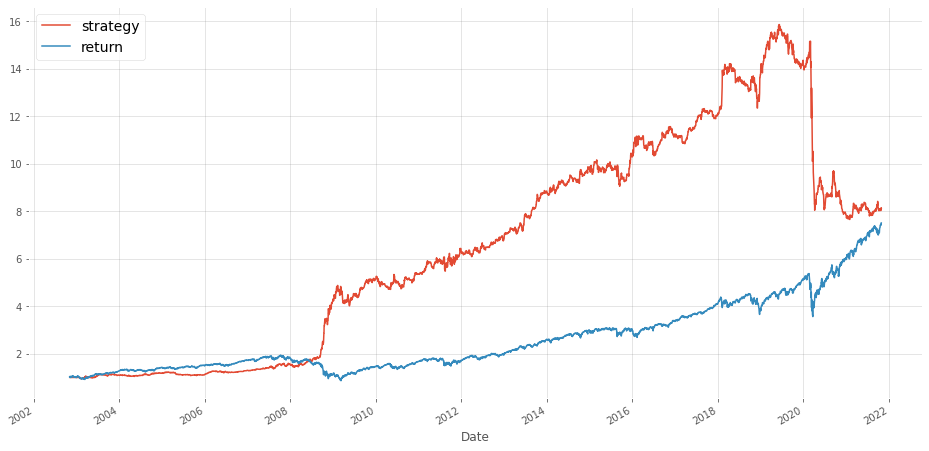

In [58]:
SP500[["strategy","return"]
     ].cumsum().apply(np.exp).plot(figsize = (16,8))
SP500[["strategy","return"]
     ].cumsum().apply(np.exp)

#### 2.1.2.3 Annual Growth Rate
##### Strategy Annual Growth Rate

In [59]:
return_ms = ((SP500["strategy"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("Our strategy AGR = %.3f percentage" % return_ms)

Our strategy AGR = 11.045 percentage


##### Benchmark Annual Growth Rate

In [60]:
return_mb = ((SP500["return"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("SP500 AGR = %.3f percentage" % return_mb)

SP500 AGR = 10.602 percentage


#### 2.1.2.4 Sharpe Ratio
##### Strategy Sharpe Ratio

In [61]:
sharpe_ms = np.sqrt(253) * SP500["strategy"].mean() / SP500["strategy"].std()
print("Our strategy Sharpe Ratio = %.3f" % sharpe_ms)

Our strategy Sharpe Ratio = 0.732


##### Benchmark Sharpe Ratio 

In [62]:
sharpe_mb = np.sqrt(253) * SP500["return"].mean() / SP500["return"].std()
print("SP500 Sharpe Ratio = %.3f" % sharpe_mb)

SP500 Sharpe Ratio = 0.563


#### 2.1.2.5 Maximum Drawdown
##### Strategy Maximum Drawdown

In [63]:
drawdown_ms = (SP500["max_gross_profit"] - SP500["cumulative_return"])/ SP500["max_gross_profit"]
print("Our Strategy Maximum Drawdown is %.3f" % drawdown_ms.max())

Our Strategy Maximum Drawdown is 0.518


##### Benchmark Maximum Drawdown 

In [64]:
drawdown_mb = (SP500["max_gross_profit_benchmark"] - SP500["cumulative_return_benchmark"])/SP500["max_gross_profit_benchmark"]
print("SP500 Maximum Drawdown is %.3f" % drawdown_mb.max())

SP500 Maximum Drawdown is 0.552


##### Drawdown comparison plot¶

<AxesSubplot:xlabel='Date'>

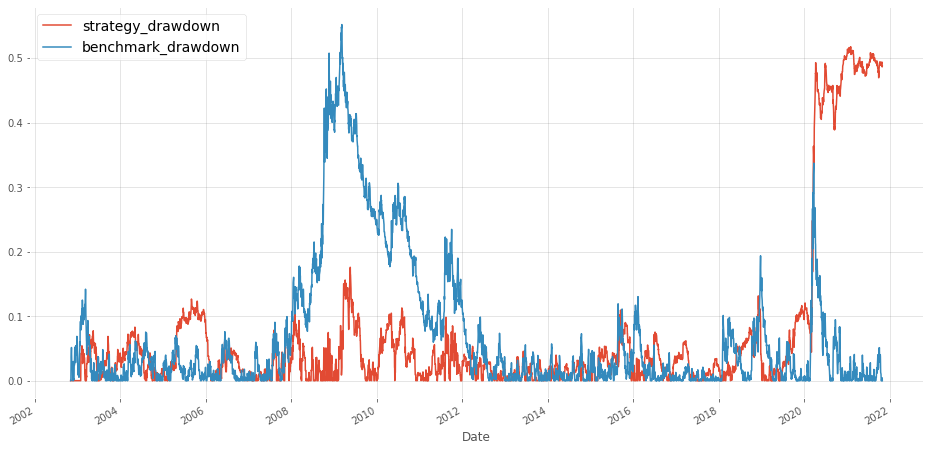

In [65]:
pd.DataFrame([drawdown_ms,drawdown_mb],index = ["strategy_drawdown","benchmark_drawdown"]).T.dropna().plot(figsize = (16,8))

#### 2.1.2.6 Final Capital after 20 Years
##### Our Strategy

In [66]:
500000 * SP500["cumulative_return"][-1]

4064161.601635995

##### Benchmark

In [67]:
500000 * SP500["cumulative_return_benchmark"][-1]

3751839.681676998

To sum up, based on the above two momentum strategies, it is obvious to see that the simple momentum strategy does not seem to have a positive effect on our goal.  On the contrary, the new momentum strategy we have adopted shows great effectiveness. Not only is the overall curve trend of the “new strategy” higher than that of the “return”, but also our technical indicators have been greatly improved, especially the Sharpe ratio and Annual growth rate which have exceeded the benchmark level, finally reaching our desired goal. 

<a id="mee"></a>

## 2.2 Mean Reversion Strategy
### 2.2.1 Strategy with 5 Days Moving Avarage

In [68]:
MR['buy_or_sell'] = np.where(MR['POSITION_5'] == 1.0, 
                       1, 0) 
MR['SIGNAL'] = MR['buy_or_sell'].diff()

#### 2.2.1.1 Buy and Sell Points

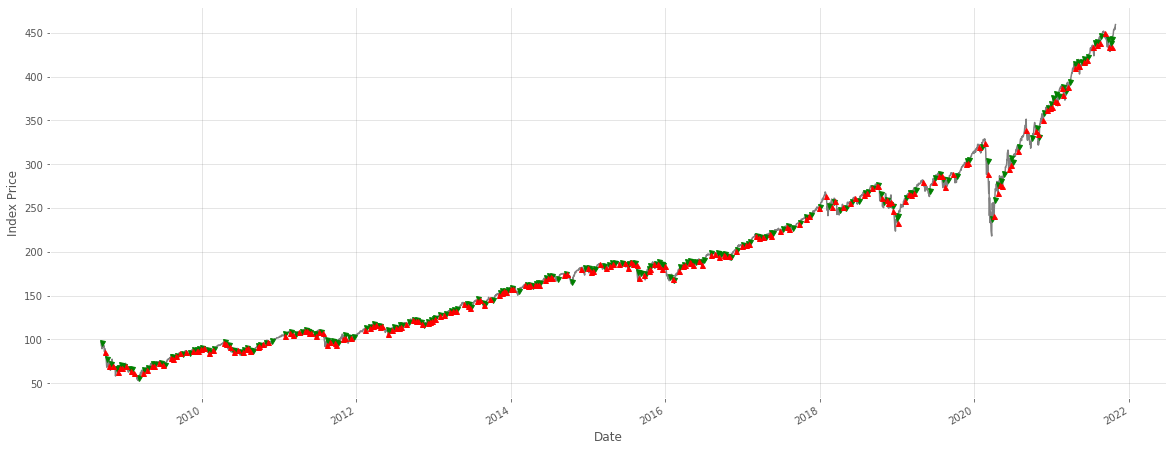

In [69]:
fig = plt.figure(figsize = (20, 8))

sub = fig.add_subplot(111, 
                     ylabel = 'Index Price')

MR['Price'].plot(ax = sub, 
                color = 'grey')

sub.plot(MR.loc[MR['SIGNAL'] == -1].index, 
        MR.Price[MR['SIGNAL'] == -1], 
        'v', 
        markersize = 5,
        color = 'green')

sub.plot(MR.loc[MR['SIGNAL'] == 1].index, 
        MR.Price[MR['SIGNAL'] == 1], 
        '^', 
        markersize = 5, 
        color = 'red')
plt.show()

#### 2.2.1.2 Cumulative Return

,STRATEGY_5,RETURNS
Date,,
2008-09-12,1.005,1.005
2008-09-15,0.957,0.957
2008-09-16,0.973,0.973
2008-09-17,0.929,0.929
2008-09-18,0.957,0.957
...,...,...
2021-10-25,2.068,4.731
2021-10-26,2.066,4.735
2021-10-27,2.076,4.714


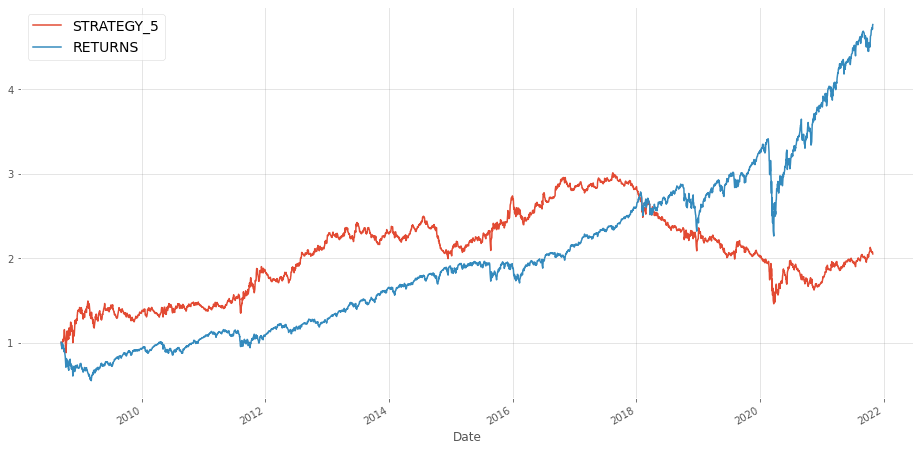

In [70]:
MR[["STRATEGY_5","RETURNS"]
     ].cumsum().apply(np.exp).plot(figsize = (16,8))
MR[["STRATEGY_5","RETURNS"]
     ].cumsum().apply(np.exp)

#### 2.2.1.3 Annual Growth Rate
##### Strategy Annual Growth Rate

In [71]:
return_mra = ((MR["STRATEGY_5"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("Our strategy AGR = %.3f percentage" % return_mra)

Our strategy AGR = 3.659 percentage


##### Benchmark Annual Growth Rate

In [72]:
return_mrb = ((MR["RETURNS"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("Benchmark AGR = %.3f percentage" % return_mrb)

Benchmark AGR = 8.124 percentage


#### 2.2.1.4 Sharpe Ratio
##### Strategy Sharpe Ratio

In [73]:
sharpe_mra = np.sqrt(253) * MR["STRATEGY_5"].mean() / MR["STRATEGY_5"].std()
print("Our strategy Sharpe Ratio = %.3f" % sharpe_mra)

Our strategy Sharpe Ratio = 0.267


##### Benchmark Sharpe Ratio

In [74]:
sharpe_mrb = np.sqrt(253) * MR["RETURNS"].mean() / MR["RETURNS"].std()
print("SP500 Sharpe Ratio = %.3f" % sharpe_mrb)

SP500 Sharpe Ratio = 0.580


#### 2.2.1.5 Maximum Drawdown
##### Strategy Maximum Drawdown

In [75]:
MR["cumulative_return"] = MR["STRATEGY_5"].cumsum().apply(np.exp)
MR["max_gross_profit"] = MR["cumulative_return"].cummax()
MR["cumulative_return_benchmark"] = MR["RETURNS"].cumsum().apply(np.exp)
MR["max_gross_profit_benchmark"] = MR["cumulative_return_benchmark"].cummax()

In [76]:
drawdown_mra = (MR["max_gross_profit"] - MR["cumulative_return"])/ MR["max_gross_profit"]
print("Our Strategy Maximum Drawdown is %.3f" % drawdown_mra.max())

Our Strategy Maximum Drawdown is 0.515


##### Benchmark Maximum Drawdown

In [77]:
drawdown_mrb = (MR["max_gross_profit_benchmark"] - MR["cumulative_return_benchmark"])/ MR["max_gross_profit_benchmark"]
print("SP500 Maximum Drawdown is %.3f" % drawdown_mrb.max())

SP500 Maximum Drawdown is 0.452


##### Drawdown comparison plot

<AxesSubplot:xlabel='Date'>

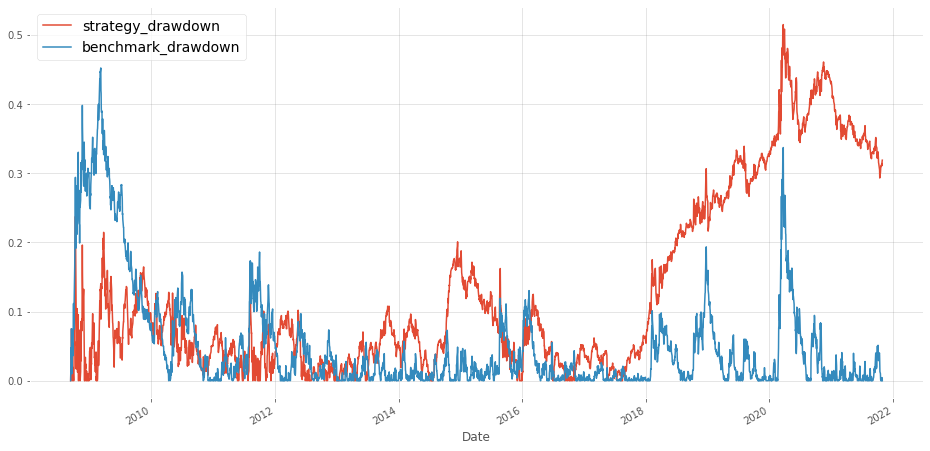

In [78]:
pd.DataFrame([drawdown_mra,drawdown_mrb],index = ["strategy_drawdown","benchmark_drawdown"]).T.dropna().plot(figsize = (16,8))

#### 2.2.1.6 Final Capital after 20 Years
###### Our Strategy

In [79]:
500000 * MR["cumulative_return"][-1]

1025841.8578380067

##### Benchmark

In [80]:
500000 * MR["cumulative_return_benchmark"][-1]

2384581.316234282

<a id="meiba"></a>

### 2.2.2 Intraday Trading of 210 minutes moving avarage

In [81]:
IntraMR['buy_or_sell'] = np.where(IntraMR['POSITION_210'] == 1.0, 
                       1, 0) 

IntraMR['SIGNAL'] = IntraMR['buy_or_sell'].diff()

#### 2.2.2.1 Buy and Sell Points

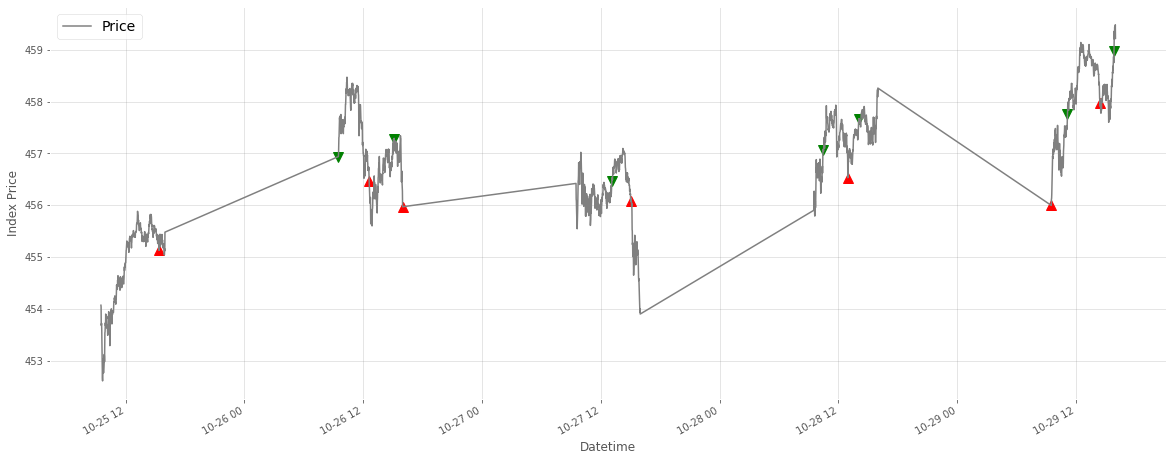

In [82]:
fig = plt.figure(figsize = (20, 8))

sub = fig.add_subplot(111, 
                     ylabel = 'Index Price')

sub.plot(IntraMR.loc[IntraMR['SIGNAL'] == -1].index, 
        IntraMR.Price[IntraMR['SIGNAL'] == -1], 
        'v', 
        markersize = 10,
        color = 'green')

sub.plot(IntraMR.loc[IntraMR['SIGNAL'] == 1].index, 
        IntraMR.Price[IntraMR['SIGNAL'] == 1], 
        '^', 
        markersize = 10, 
        color = 'red')

IntraMR[['Price']].plot(ax = sub, 
                color = 'grey')
plt.show()

#### 2.2.2.2 Cumulative Return

,STRATEGY_210,RETURNS
Datetime,,
2021-10-25 09:31:00-04:00,NaN,1.000
2021-10-25 09:32:00-04:00,1.000,1.000
2021-10-25 09:33:00-04:00,1.000,0.999
2021-10-25 09:34:00-04:00,1.000,0.999
2021-10-25 09:35:00-04:00,1.000,0.999
...,...,...
2021-10-29 15:55:00-04:00,1.027,1.012
2021-10-29 15:56:00-04:00,1.027,1.011
2021-10-29 15:57:00-04:00,1.027,1.012


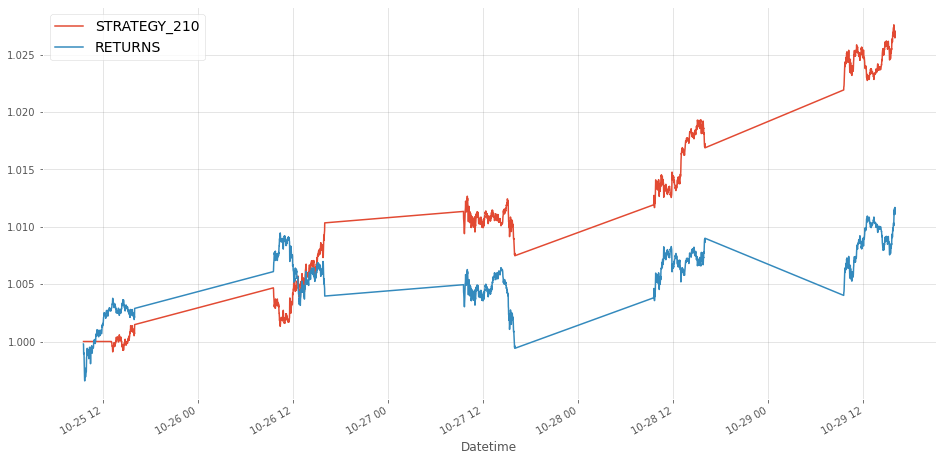

In [83]:
IntraMR[["STRATEGY_210","RETURNS"]
     ].cumsum().apply(np.exp).plot(figsize = (16,8))
IntraMR[["STRATEGY_210","RETURNS"]
     ].cumsum().apply(np.exp)

#### 2.2.2.3 Strategy Annual Growth Rate

##### Strategy Annual Growth Rate

In [84]:
return_mra = ((IntraMR["STRATEGY_210"].cumsum().apply(np.exp)[-1]) ** (253/5) - 1)*100
print("Our strategy AGR = %.3f percentage" % return_mra)

Our strategy AGR = 286.023 percentage


##### Benchmark Annual Growth Rate

In [85]:
return_mrab = ((IntraMR["RETURNS"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("Benchmark AGR = %.3f percentage" % return_mrb)

Benchmark AGR = 8.124 percentage


#### 2.2.2.4 Sharpe Ratio
##### Our Strategy Sharpe Ratio

In [86]:
Sharpe = np.sqrt(253) * (IntraMR['STRATEGY_210'].mean() / IntraMR['STRATEGY_210'].std())
Sharpe

0.8210935557796634

##### Benchmark Sharpe Ratio 

In [87]:
sharpe_mrab = np.sqrt(253) * IntraMR["RETURNS"].mean() / IntraMR["RETURNS"].std()
print("SP500 Sharpe Ratio = %.3f" % sharpe_mrb)

SP500 Sharpe Ratio = 0.580


#### 2.2.2.5 Strategy Maximum Drawdown

In [88]:
IntraMR["cumulative_return"] = IntraMR["STRATEGY_210"].cumsum().apply(np.exp)
IntraMR["max_gross_profit"] = IntraMR["cumulative_return"].cummax()
IntraMR["cumulative_return_benchmark"] = IntraMR["RETURNS"].cumsum().apply(np.exp)
IntraMR["max_gross_profit_benchmark"] = IntraMR["cumulative_return_benchmark"].cummax()

In [89]:
drawdown_mrs = (IntraMR["max_gross_profit"] - IntraMR["cumulative_return"])/ IntraMR["max_gross_profit"]
print("Our Strategy Maximum Drawdown is %.3f" % drawdown_mrs.max())

Our Strategy Maximum Drawdown is 0.005


#### 2.2.2.6 Final Capital after 20 Years

##### Our Strategy

In [90]:
500000 * (IntraMR["cumulative_return"][-1]) ** ((253/5)*20)

2.6992450539347776e+17

##### Benchmark 

In [91]:
500000 * IntraMR["cumulative_return_benchmark"][-1]

505559.5786199705

### 2.2.3 RSI Strategy of 65 overbought and 35 oversold

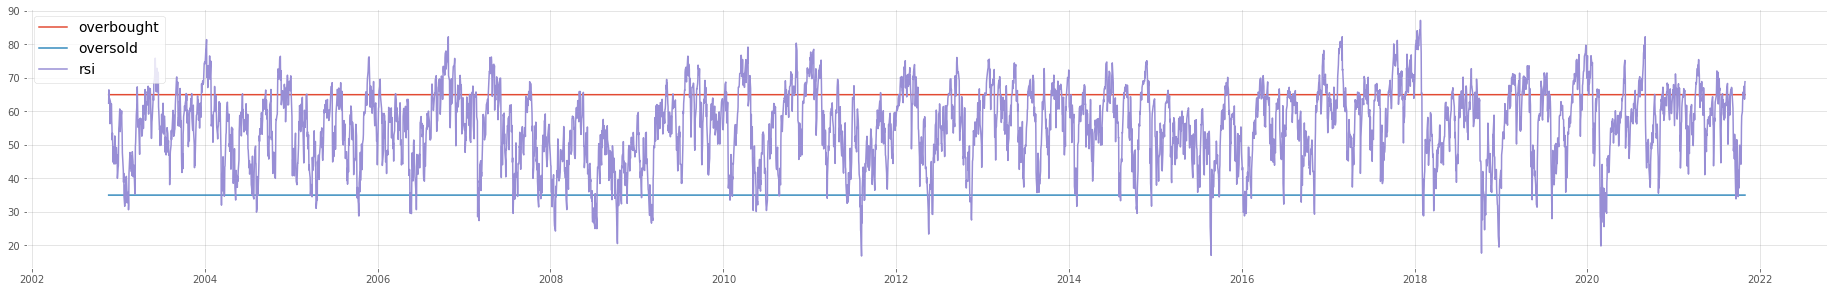

In [92]:
fig = plt.figure()
fig.set_size_inches((25, 18))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))
ax_rsi.plot(rsi.index, 
           [65]* len(rsi.index), 
           label = 'overbought')
ax_rsi.plot(rsi.index, 
           [35] * len(rsi.index), 
           label = 'oversold')
ax_rsi.plot(rsi.index, 
            rsi["RSI"], 
           label = 'rsi')

ax_rsi.legend()

#### 2.2.3.1 Buy and Sell point

In [93]:
rsi['buy_or_sell'] = np.where(rsi['POSITION_65'] == 1.0, 
                       1, 0) 
rsi['SIGNAL'] = rsi['buy_or_sell'].diff()

rsi['SIGNAL'].value_counts()

0.000     3657
-1.000     556
1.000      555
Name: SIGNAL, dtype: int64

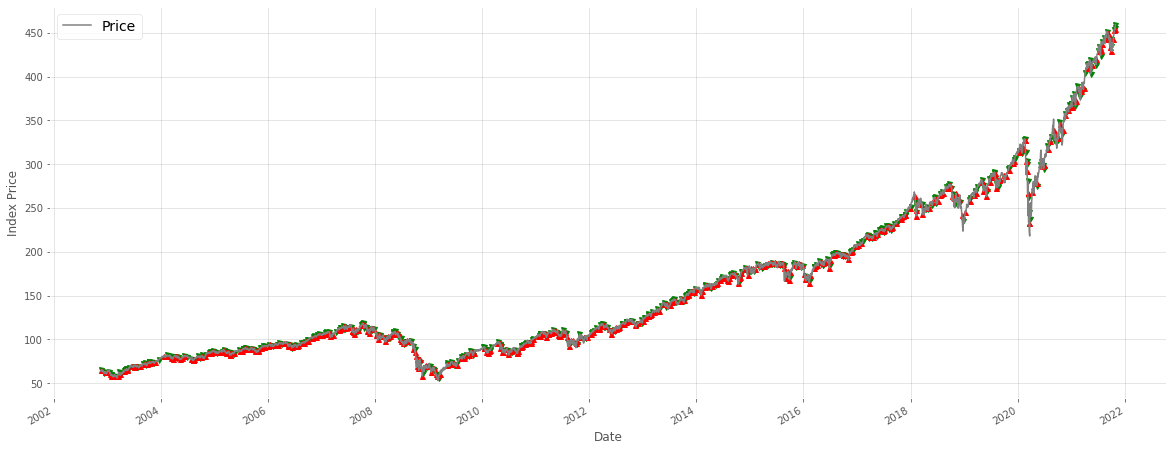

In [94]:
fig = plt.figure(figsize = (20, 8))

sub = fig.add_subplot(111, 
                     ylabel = 'Index Price')

sub.plot(rsi.loc[rsi['SIGNAL'] == -1].index, 
        rsi.Price[rsi['SIGNAL'] == -1], 
        'v', 
        markersize = 5,
        color = 'green')

sub.plot(rsi.loc[rsi['SIGNAL'] == 1].index, 
        rsi.Price[rsi['SIGNAL'] == 1], 
        '^', 
        markersize = 5 , 
        color = 'red')
rsi[['Price']].plot(ax = sub, 
                color = 'grey')
plt.show()

#### 2.2.3.2 Cummulative Return

,STRATEGY_65,RETURNS
Date,,
2002-11-20,NaN,1.022
2002-11-21,1.019,1.041
2002-11-22,1.026,1.034
2002-11-25,1.027,1.035
2002-11-26,1.007,1.015
...,...,...
2021-10-25,4.869,7.292
2021-10-26,4.865,7.298
2021-10-27,4.886,7.266


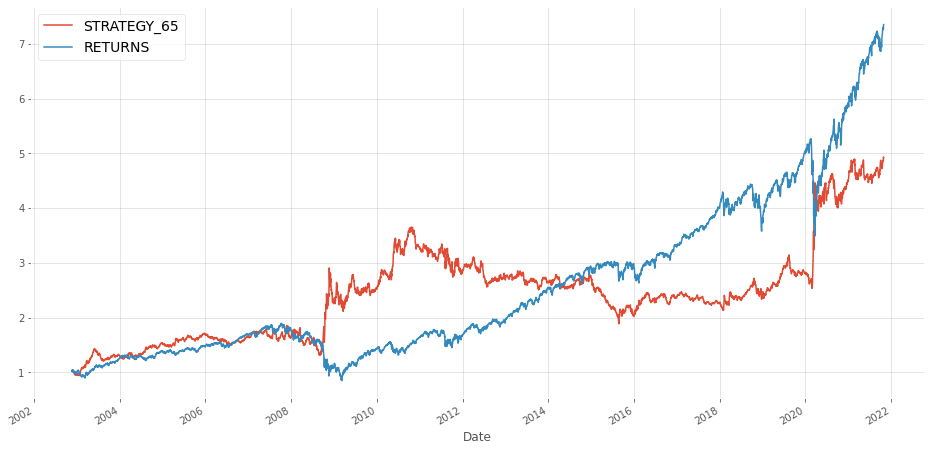

In [95]:
rsi[["STRATEGY_65","RETURNS"]
     ].cumsum().apply(np.exp).plot(figsize = (16,8))
rsi[["STRATEGY_65","RETURNS"]
     ].cumsum().apply(np.exp)

#### 2.2.3.3 Annual Growth Rate
##### Strategy Annual Growth Rate

In [96]:
return_mrr = ((rsi["STRATEGY_65"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("Our strategy AGR = %.3f percentage" % return_mrr)

Our strategy AGR = 8.296 percentage


##### Benchmark Annual Growth Rate

In [97]:
return_mrrb = ((rsi["RETURNS"].cumsum().apply(np.exp)[-1]) ** (1/20) - 1)*100
print("Our strategy AGR = %.3f percentage" % return_mrrb)

Our strategy AGR = 10.488 percentage


#### 2.2.3.4 Sharpe Ratio
##### Strategy Sharpe Ratio

In [98]:
sharpe_rsi = np.sqrt(253) * rsi["STRATEGY_65"].mean() / rsi["STRATEGY_65"].std()
print("Our strategy Sharpe Ratio = %.3f" % sharpe_rsi)

Our strategy Sharpe Ratio = 0.447


##### Benchmark Sharpe Ratio

In [99]:
sharpe_rb = np.sqrt(253) * rsi["RETURNS"].mean() / rsi["RETURNS"].std()
print("Our strategy Sharpe Ratio = %.3f" % sharpe_rb)

Our strategy Sharpe Ratio = 0.559


#### 2.2.3.5 Strategy Maximum Drawdown 

In [100]:
rsi["cumulative_return"] = rsi["STRATEGY_65"].cumsum().apply(np.exp)
rsi["max_gross_profit"] = rsi["cumulative_return"].cummax()
rsi["cumulative_return_benchmark"] = rsi["RETURNS"].cumsum().apply(np.exp)
rsi["max_gross_profit_benchmark"] = rsi["cumulative_return_benchmark"].cummax()

In [101]:
drawdown_rsi = (rsi["max_gross_profit"] - rsi["cumulative_return"])/ rsi["max_gross_profit"]
print("Our Strategy Maximum Drawdown is %.3f" % drawdown_rsi.max())

Our Strategy Maximum Drawdown is 0.484


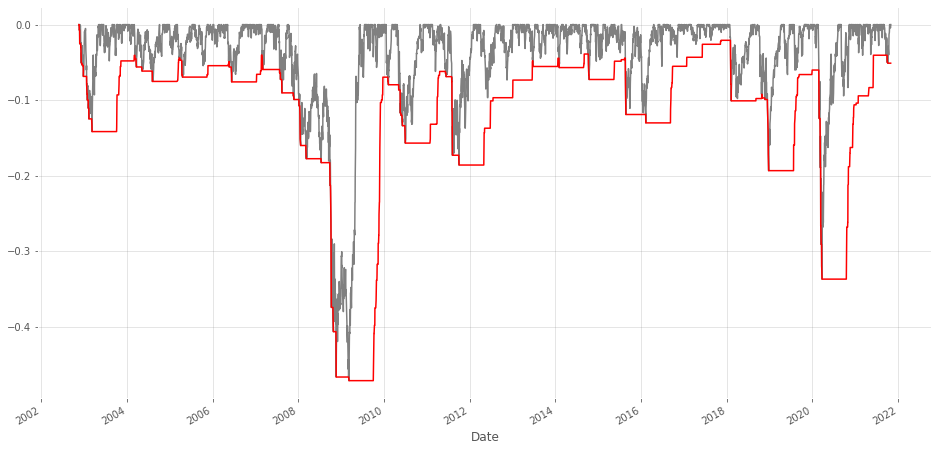

In [102]:
rolling_max_drawdown = rsi["Price"].rolling(window = 146,
                                               min_periods = 1).max() 

drawdown_daily = rsi["Price"] / rolling_max_drawdown - 1.0 

max_drawdown_daily = drawdown_daily.rolling(window = 146,
                                            min_periods = 1).min() 

fig = plt.figure(figsize = (16,8)
                 )

drawdown_daily.plot(color = "grey")
max_drawdown_daily.plot(color = "red") # This is your focal point of interest here.

plt.show()

##### Drawdown comparison plot

<AxesSubplot:xlabel='Date'>

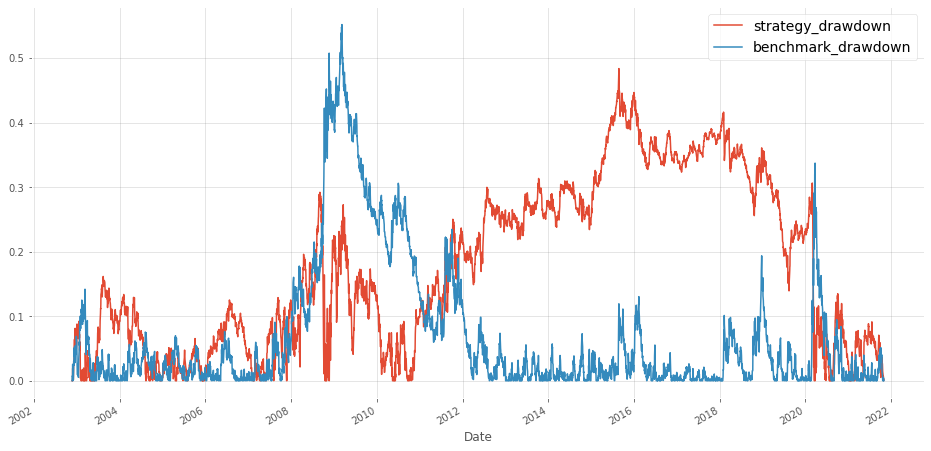

In [103]:
pd.DataFrame([drawdown_rsi,drawdown_mb],index = ["strategy_drawdown","benchmark_drawdown"]).T.dropna().plot(figsize = (16,8))

#### 2.2.3.6 Final Capital after 20 Years 

##### Our Strategy 

In [104]:
500000 * rsi["cumulative_return"][-1]

2461783.779410469

##### Benchmark 

In [105]:
500000 * rsi["cumulative_return_benchmark"][-1]

3675440.429870627

<a id="maa"></a>

### 2.3 Machine Learning (ETR)
#### 2.3.1 Cummulative Return

In [106]:
Y[["Return", "ETR"]].sum().apply(np.exp)

Return                  6.873
ETR      2841328297587872.500
dtype: float64

In [107]:
portfolio = 500000 * Y[["ETR"]].sum().apply(np.exp)
portfolio

ETR   1420664148793936314368.000
dtype: float64

#### 2.3.2 Sharpe Ratio

In [108]:
np.sqrt(252) * (Y[["Return", "ETR"]].mean() / Y[["Return", "ETR"]].std())

Return    0.546
ETR      13.038
dtype: float64

#### 2.3.3 CAGR

In [109]:
Y[["ETR"]].sum().apply(np.exp) * (1/20)

ETR   142066414879393.625
dtype: float64

<a id="sum"></a>

# Part III `Summary`

<a id="a"></a>
## Strategy A: Machine Learning -- ETR 
- Compound Annual Growth Rate: 14563891382290215.6% 
- Sharpe Ratio: 13.040 
- Max Drawdown: N/A 
- Final Capital:142070218161056.312

#### Compared to the benchmark
- Compound Annual Growth Rate: 10.602% 
- Sharpe Ratio: 0.563 
- Max Drawdown: 0.552 
- Final Capital: 3751839.447

#### [Go to the Strategy Building Part](#ma)

#### [Go to the Strategy Backtesting Part](#maa)

The results obtained from the Machine Learning algorithm when backtested on in sample data is very unrealistic as the model has been trained on the same data and is tuned to perfectly predict what it has already seen. This results in our capital being compounded by the absolute value of daily returns for the last 20 years. Due to this we obtain an unreasonable growth rate and sharpe rate. Also, there is no drawdown as the model performs with a 100% accuracy. 

In practice, the model chosen will be based upon how well it can predict future data on untrained parameters. This will greatly reduce the efficiency of the model compared to the one we have worked on in this project. 

<a id="b"></a>
## Strategy B: Mean Reversion Strategy -- Intraday Trading

- Compound Annual Growth Rate: 14563891382290215.6% 
- Sharpe Ratio: 13.040 
- Max Drawdown: 0.005
- Final Capital: 2.6992450539347776e+17

#### Compared to the benchmark
- Compound Annual Growth Rate: 10.602% 
- Sharpe Ratio: 0.821 
- Max Drawdown: 0.552  
- Final Capital: 3751839.447

#### [Go to the Strategy Building Part](#mei)

#### [Go to the Strategy Backtesting Part](#meiba)

<a id="c"></a>
## Strategy C: Momentum Strategy -- New Defined Momentum

- Compound Annual Growth Rate: 11.045% 
- Sharpe Ratio: 0.732  
- Max Drawdown: 0.518 
- Final Capital: 4064310.108

#### Compared to the benchmark
- Compound Annual Growth Rate: 10.602% 
- Sharpe Ratio: 0.821 
- Max Drawdown: 0.552 
- Final Capital: 3751839.447

#### [Go to the Strategy Building Part](#mon)

#### [Go to the Strategy Backtesting Part](#monba)

<a id="te"></a>

# Teamwork

All group members worked really well as a team. Chengfan was in charge of the momentum strategy, Xianyuan took care of the mean reversion strategy and Devesh did the machine learning strategy. Zerui had an overview of the entire code and fine-tuned each part to try to produce a better outcome and make our work presentable.  
At the same time, we were constantly discussing each other's strategies. When someone had a problem, the others offered suggestions and improvements. We all gained a lot from this project and from each other, and enjoyed the work a lot. 